In [62]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
import warnings
from pandas.core.nanops import nanmean as pd_nanmean
from scipy.signal import periodogram

from sklearn.metrics import mean_absolute_error
import random
import seaborn as sns

from IPython.display import *

from scipy import stats

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
from sklearn.metrics import mean_squared_error
from math import sqrt
    
def rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Датасет Avocado Prices
https://www.kaggle.com/neuromusic/avocado-prices

In [16]:
df = pd.read_csv('avocado.csv')
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
Unnamed: 0      18249 non-null int64
Date            18249 non-null object
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


# Предобработка данных

Перед нами информация о ценах на авокадо за несколько лет. Попробуем проанализировать эту информацию.
<br>
Для начала уберем из датасета лишние данные, оставив те, которые влияют на цену авокадо. То есть тип и регион и дату покупки.

In [17]:
df.drop(columns = ['Unnamed: 0','Total Volume','4046','4225','4770','Total Bags','Small Bags', 'Large Bags','XLarge Bags', 'year'], inplace = True)
df

,Date,AveragePrice,type,region
0,2015-12-27,1.33,conventional,Albany
1,2015-12-20,1.35,conventional,Albany
2,2015-12-13,0.93,conventional,Albany
3,2015-12-06,1.08,conventional,Albany
4,2015-11-29,1.28,conventional,Albany
...,...,...,...,...
18244,2018-02-04,1.63,organic,WestTexNewMexico
18245,2018-01-28,1.71,organic,WestTexNewMexico
18246,2018-01-21,1.87,organic,WestTexNewMexico
18247,2018-01-14,1.93,organic,WestTexNewMexico


Преобразуем к временному ряду

In [18]:
df.sort_values('Date', axis = 0, inplace = True)
df['Date'] = pd.to_datetime(df.Date, format = '%Y-%m-%d')
df.index = df.Date
df.drop('Date',axis = 1, inplace = True)
df

,AveragePrice,type,region
Date,,,
2015-01-04,1.75,organic,Southeast
2015-01-04,1.49,organic,Chicago
2015-01-04,1.68,organic,HarrisburgScranton
2015-01-04,1.52,conventional,Pittsburgh
2015-01-04,1.64,organic,Boise
...,...,...,...
2018-03-25,1.36,conventional,Chicago
2018-03-25,0.70,conventional,SouthCentral
2018-03-25,1.42,organic,SouthCentral


# Проверка статистических гипотез

Посмотрим на распределение цен

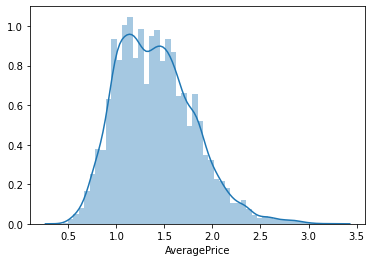

In [27]:
sns.distplot(df['AveragePrice'])

Видим, что у распределения два центра около 1 и 1,5, возможно это из-за типа авокадо.

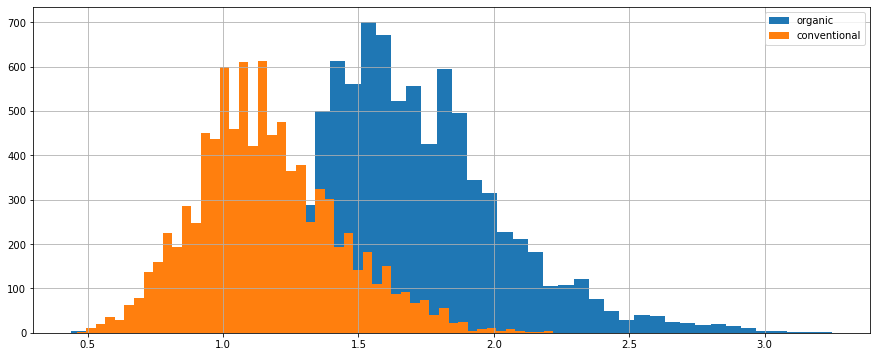

In [31]:
df[df.type == 'organic'].AveragePrice.hist(bins = 50, figsize = (15,6), label = 'organic')
df[df.type == 'conventional'].AveragePrice.hist(bins = 50, figsize = (15,6), label = 'conventional')
plt.legend()

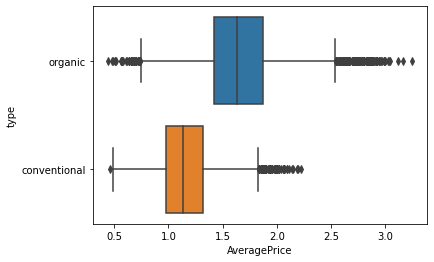

In [46]:
sns.boxplot(y="type", x="AveragePrice", data=df)

Действительно, наблюдаем, что цена зависит от типа авокадо, причем кажется, что цена на органический тип выше, чем на неорганический, проверим так ли это.
<br>
Гипотеза: цена на органический тип авокадо выше, чем на неорганический.

Для начала проверим распределения на нормальность с помощью критерия Шапиро-Уилка

In [122]:
organic = df[df.type == 'organic']
conventional = df[df.type == 'conventional']
print('organic','is normal' if stats.shapiro(organic['AveragePrice'])[1] > 0.05 else 'is not normal',
      '\nconventional', 'is normal' if stats.shapiro(conventional['AveragePrice'])[1] > 0.05 else 'is not normal')

organic is not normal 
conventional is not normal


Данные распределены не нормально, следовательно критерий стьюдента неприменим.
<br>
Поэтому воспользуемся критерием Манна-Уитни

In [43]:
print(stats.mannwhitneyu(organic['AveragePrice'], conventional['AveragePrice'], alternative='greater'))
print(stats.mannwhitneyu(organic['AveragePrice'], conventional['AveragePrice'], alternative='less'))

MannwhitneyuResult(statistic=72573720.0, pvalue=0.0)
MannwhitneyuResult(statistic=72573720.0, pvalue=1.0)


Наша гипотеза подтвердилась: цена на органический тип авокадо выше, чем на неорганический.

Получили, что медиана цен у органических продуктов выше, чем у неорганических. Логично.

# Предсказание временного ряда

Так как цена на авокадо зависит от типа, будем делать предсказание для одного типа, например органического.

Посмотрим, как цены зависят от времени

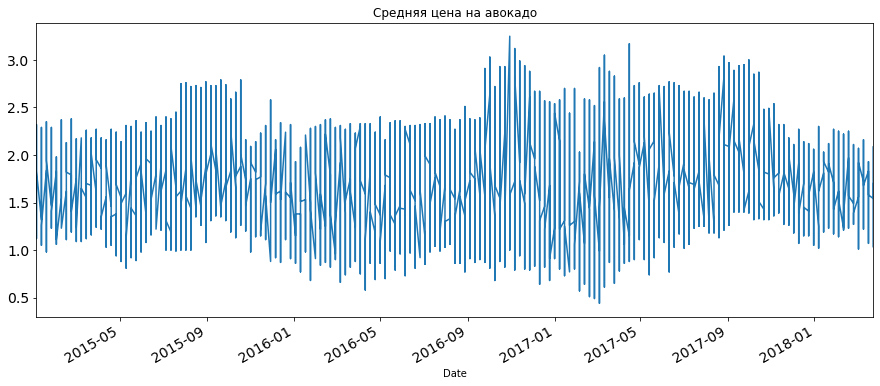

In [123]:
organic.AveragePrice.plot(figsize = (15,6),title = 'Средняя цена на авокадо', fontsize = 14)

График получился странным, потому что в день происходит несколько закупок. Поэтому будем анализировать среднюю цену закупки в день.

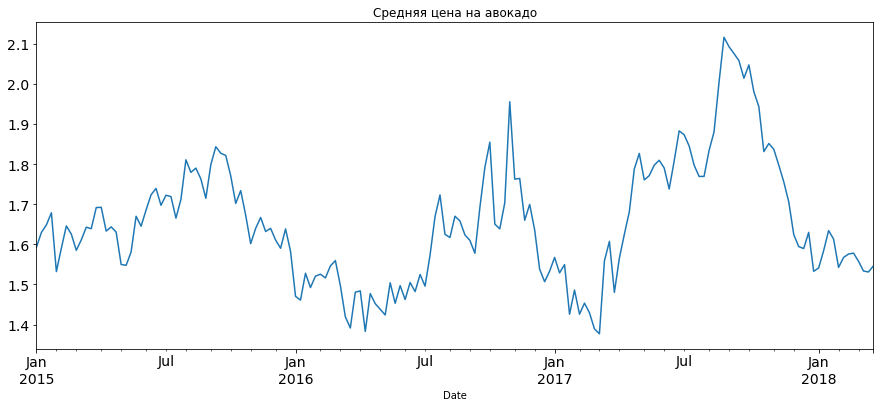

In [125]:
organic = organic.groupby(organic.index).mean()
organic.AveragePrice.plot(figsize = (15,6),title = 'Средняя цена на авокадо', fontsize = 14)

Проверим ряд на стационарность

In [71]:
print('Ряд не стационарен' if sm.tsa.adfuller(organic['AveragePrice'])[1] > 0.05 else 'Ряд стационарен')

Ряд стационарен


Так как ряд стационарен, у него нет тренда и сезонности, тогда для предсказания применим метод экспоненциального сглаживания.

Предскажем цену на начало 2018 года

In [126]:
len_2018 = organic[organic.index.year == 2018].count()[0]
train = organic[:-len_2018]
test = organic[-len_2018:]
y_hat = test.copy()

([], <a list of 0 Text major ticklabel objects>)

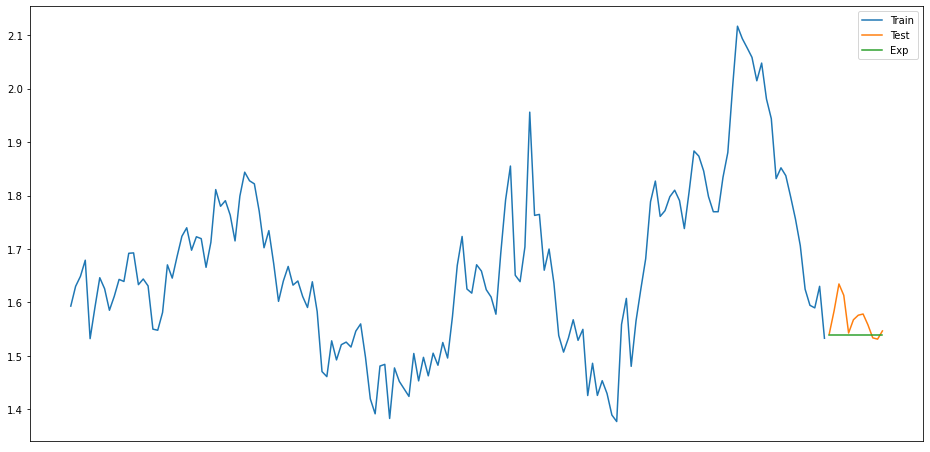

In [127]:
fit = ExponentialSmoothing(np.asarray(train.AveragePrice)).fit()
y_hat['AveragePrice'] = fit.forecast(len(test))

fig = plt.figure(figsize=(16,8))
plt.plot(train['AveragePrice'], label='Train')
plt.plot(test['AveragePrice'], label='Test')
plt.plot(y_hat['AveragePrice'], label='Exp')
plt.legend()
plt.xticks([])